## MNIST Fashion Classification
Gary Agasa

Fudan University

garyagasa547@gmail.com

### Part I. Preparation and Data Processing

#### Import necessary packages

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [18]:
# 设置随机种子保证可重复性
torch.manual_seed(42)
np.random.seed(42)

Check the device

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


Set the batch size

In [20]:
batch_size = 128

#### Data Preparation

In [21]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST的均值和标准差
    ])
        
# 加载训练集
train_dataset = datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
        
# 分割训练集和验证集
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
        
# 加载测试集
test_dataset = datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)
        
# 创建数据加载器
train_loader = DataLoader(
    train_subset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_subset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2
)
        
print(f"traing set size: {len(train_subset)}")
print(f"validation set size: {len(val_subset)}")
print(f"training set size: {len(test_dataset)}")

traing set size: 48000
validation set size: 12000
training set size: 10000


### Part II. Model

#### Model Architechture

In [ ]:
class CNNMnist(nn.Module):
    """CNN模型用于衣物分类识别"""
    def __init__(self, num_classes=10):
        super(CNNMnist, self).__init__()
        # 第一个卷积层块
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28x1 -> 28x28x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # 28x28x32 -> 28x28x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                 # 28x28x32 -> 14x14x32
            nn.Dropout(0.25)
        )
        
        # 第二个卷积层块
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 14x14x32 -> 14x14x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # 14x14x64 -> 14x14x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                 # 14x14x64 -> 7x7x64
            nn.Dropout(0.25)
        )
        
        # 全连接层
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

#### Model Set Up

In [23]:
learning_rate = 0.001

"""设置模型和优化器"""
model = CNNMnist(num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
        
# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)
        
print("Model Architechture:")
print(model)

Model Architechture:
CNNMnist(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_si

### Part III. Training and Validation

#### Train an epoch

In [24]:
def train_epoch():
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
            
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
            
        if batch_idx % 100 == 0:
            print(f'batch index: {batch_idx}/{len(train_loader)}, '
                    f'Loss: {loss.item():.4f}')
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
        
    return epoch_loss, epoch_acc

#### Validate an epoch

In [25]:
def validate_epoch():
    """验证一个epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
        
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
                
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
        
    return epoch_loss, epoch_acc

histories

In [26]:
# 训练历史记录
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

#### Train the model and Validation

In [27]:
"""训练模型"""
print("开始训练...")
best_val_acc = 0.0
epochs = 10
        
for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    print('-' * 50)
            
    # 训练和验证
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = validate_epoch()
            
    # 更新学习率
    scheduler.step(val_loss)
            
    # 记录历史
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
            
    print(f'训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.2f}%')
    print(f'验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.2f}%')
            
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_mnist_model.pth')
        print(f'新的最佳模型已保存! 验证准确率: {val_acc:.2f}%')

开始训练...

Epoch 1/10
--------------------------------------------------
batch index: 0/375, Loss: 2.5264
batch index: 100/375, Loss: 0.4336
batch index: 200/375, Loss: 0.4116
batch index: 300/375, Loss: 0.4179
训练损失: 0.4674, 训练准确率: 83.57%
验证损失: 0.2837, 验证准确率: 89.48%
新的最佳模型已保存! 验证准确率: 89.48%

Epoch 2/10
--------------------------------------------------
batch index: 0/375, Loss: 0.2765
batch index: 100/375, Loss: 0.3477
batch index: 200/375, Loss: 0.2638
batch index: 300/375, Loss: 0.2277
训练损失: 0.2989, 训练准确率: 89.20%
验证损失: 0.2345, 验证准确率: 91.39%
新的最佳模型已保存! 验证准确率: 91.39%

Epoch 3/10
--------------------------------------------------
batch index: 0/375, Loss: 0.2527
batch index: 100/375, Loss: 0.2193
batch index: 200/375, Loss: 0.1751
batch index: 300/375, Loss: 0.3006
训练损失: 0.2637, 训练准确率: 90.38%
验证损失: 0.2216, 验证准确率: 91.76%
新的最佳模型已保存! 验证准确率: 91.76%

Epoch 4/10
--------------------------------------------------
batch index: 0/375, Loss: 0.2651
batch index: 100/375, Loss: 0.4118
batch index: 20

### Part IV. Evaluation

#### Evaluate

In [28]:
"""评估模型在测试集上的表现"""
model.load_state_dict(torch.load('best_mnist_model.pth'))
model.eval()
        
test_loss = 0
correct = 0
total = 0

test_acc = 0
all_predictions = []
all_targets = []
        
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
                
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
                
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
        
    print(f'测试损失: {test_loss:.4f}')
    print(f'测试准确率: {test_acc:.2f}%')
        
    # 显示分类报告
    print("\n分类报告:")
    print(classification_report(all_targets, all_predictions, digits=4))

测试损失: 0.1938
测试准确率: 93.17%

分类报告:
              precision    recall  f1-score   support

           0     0.8911    0.8920    0.8916      1000
           1     0.9940    0.9930    0.9935      1000
           2     0.9048    0.9030    0.9039      1000
           3     0.9232    0.9500    0.9364      1000
           4     0.8381    0.9470    0.8892      1000
           5     0.9920    0.9870    0.9895      1000
           6     0.8512    0.7150    0.7772      1000
           7     0.9517    0.9850    0.9681      1000
           8     0.9890    0.9920    0.9905      1000
           9     0.9825    0.9530    0.9675      1000

    accuracy                         0.9317     10000
   macro avg     0.9318    0.9317    0.9307     10000
weighted avg     0.9318    0.9317    0.9307     10000



#### Visualization

In [29]:
def plot_training_history():
    """绘制训练历史"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
    # 绘制损失曲线
    ax1.plot(train_losses, label='training loss')
    ax1.plot(val_losses, label='validation loss')
    ax1.set_title('training and validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
        
    # 绘制准确率曲线
    ax2.plot(train_accuracies, label='training accuracy')
    ax2.plot(val_accuracies, label='validation accuracy')
    ax2.set_title('training and validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('accuracy (%)')
    ax2.legend()
    ax2.grid(True)
        
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()   

In [30]:
def plot_confusion_matrix(predictions, targets):
    """绘制混淆矩阵"""
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=range(10), yticklabels=range(10))
    plt.title('confusion matrix')
    plt.xlabel('predicted label')
    plt.ylabel('real label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
def visualize_predictions(num_samples=10):
        """可视化一些预测结果"""
        model.eval()
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        # 转换为CPU numpy数组
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()
        
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()
        
        for i in range(num_samples):
            axes[i].imshow(images[i].squeeze(), cmap='gray')
            axes[i].set_title(f'real: {labels[i]}, predicted: {predicted[i]}')
            axes[i].axis('off')
            # 如果预测错误，用红色边框标记
            if labels[i] != predicted[i]:
                axes[i].spines['bottom'].set_color('red')
                axes[i].spines['top'].set_color('red') 
                axes[i].spines['right'].set_color('red')
                axes[i].spines['left'].set_color('red')
                axes[i].spines['bottom'].set_linewidth(3)
                axes[i].spines['top'].set_linewidth(3) 
                axes[i].spines['right'].set_linewidth(3)
                axes[i].spines['left'].set_linewidth(3)
        
        plt.tight_layout()
        plt.savefig('predictions_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()

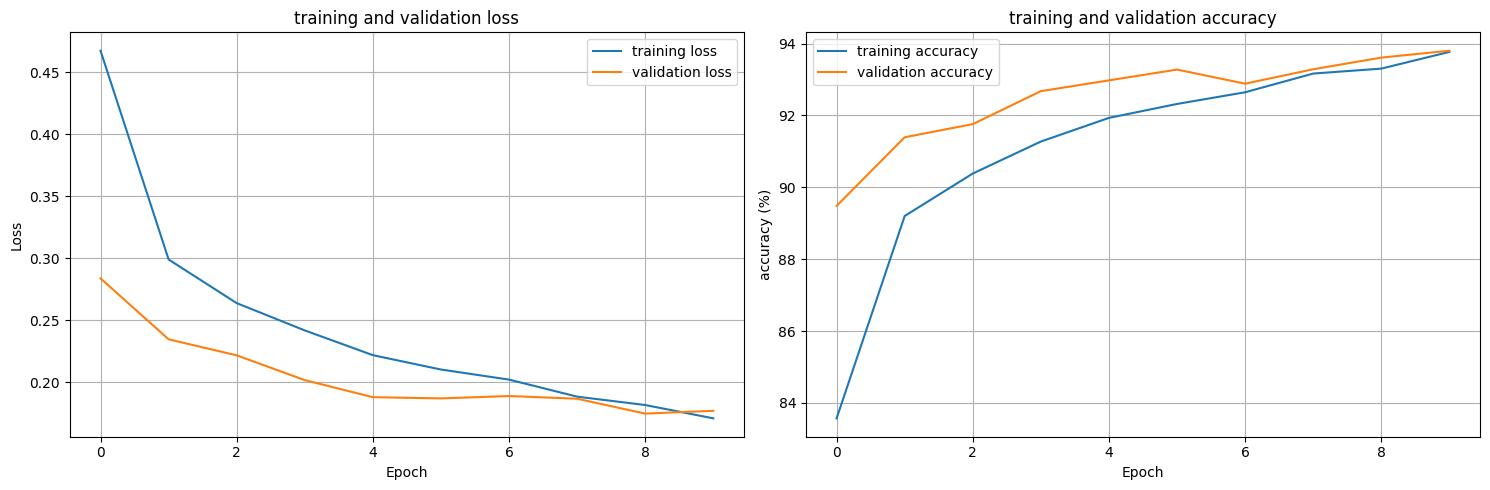

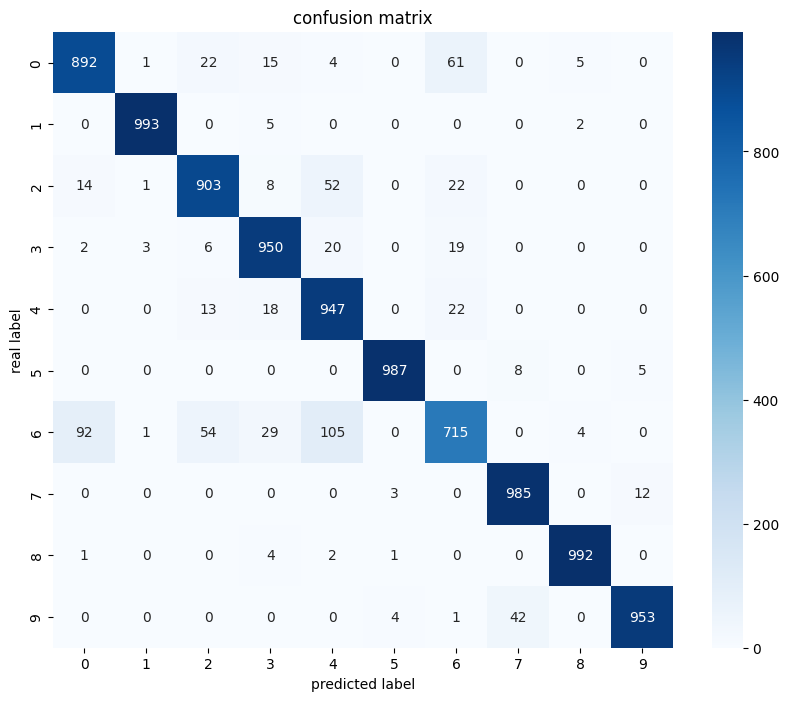

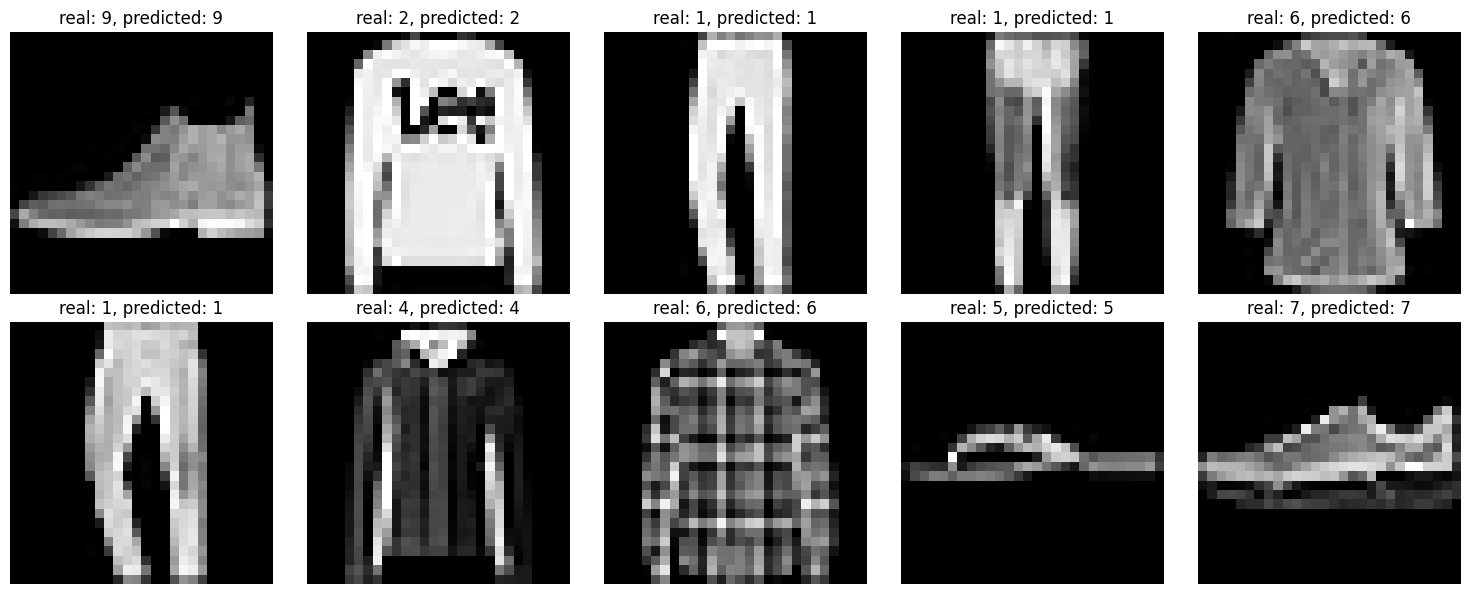


最终测试准确率: 93.17%


In [32]:
# 可视化结果
plot_training_history()
plot_confusion_matrix(all_predictions, all_targets)
visualize_predictions()
    
print(f"\n最终测试准确率: {test_acc:.2f}%")